# Training a CNN classifier with VAE augmented data

### Imports

In [1]:
import mlflow
import torch
import vae
from utils.mlflow import backend_stores
from utils.trainer import TrainingArguments
from vae.models import VAEConfig
from evaluation.models import CNNMNIST
from evaluation.train_utils import train_model
from utils.data import get_dataset, load_splitted_datasets, load_unsplitted_dataset
from vae.generation import augmentations
from vae.generation2 import DataAugmentation
from torch.utils.data import ConcatDataset

### Seeding, loading data & setting up mlflow logging

In [2]:
SEED = 1337
DATASET = "MNIST"
# seed torch
torch.manual_seed(SEED)
# set model store path
vae.models.base.model_store = "pretrained_models/MNIST"
# set the backend store uri of mlflow
mlflow.set_tracking_uri(getattr(backend_stores, DATASET))

### Parameters for data augmentation

In [3]:
MULTI_VAE = False
VAE_EPOCHS = 100
Z_DIM = 10
BETA = 1.0
AUGMENTATION = augmentations.REPARAMETRIZATION
K = 450
augmentation_params = {}

## Data Augmentation

n = 10
x = tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
L = tensor([45, 45, 45, 45, 45, 45, 45, 45, 45, 45])


/home/yi01371/dev/data-augmentation/src/vae/visualization/vis.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15, 15))


500


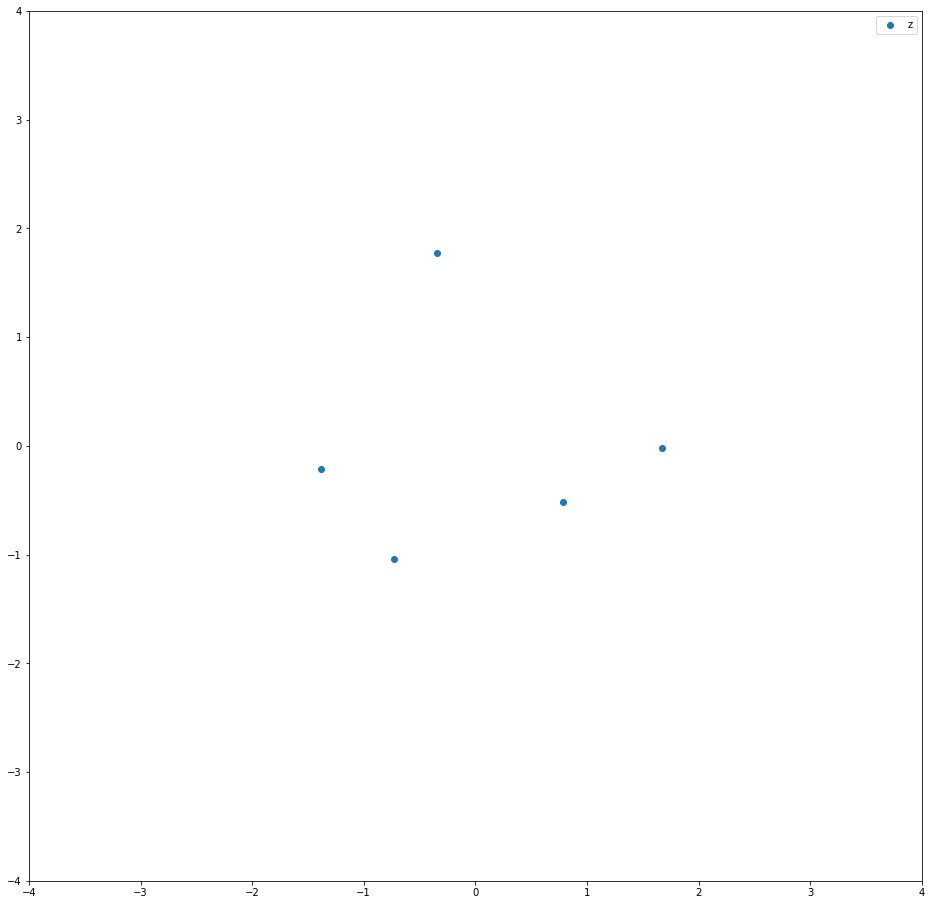

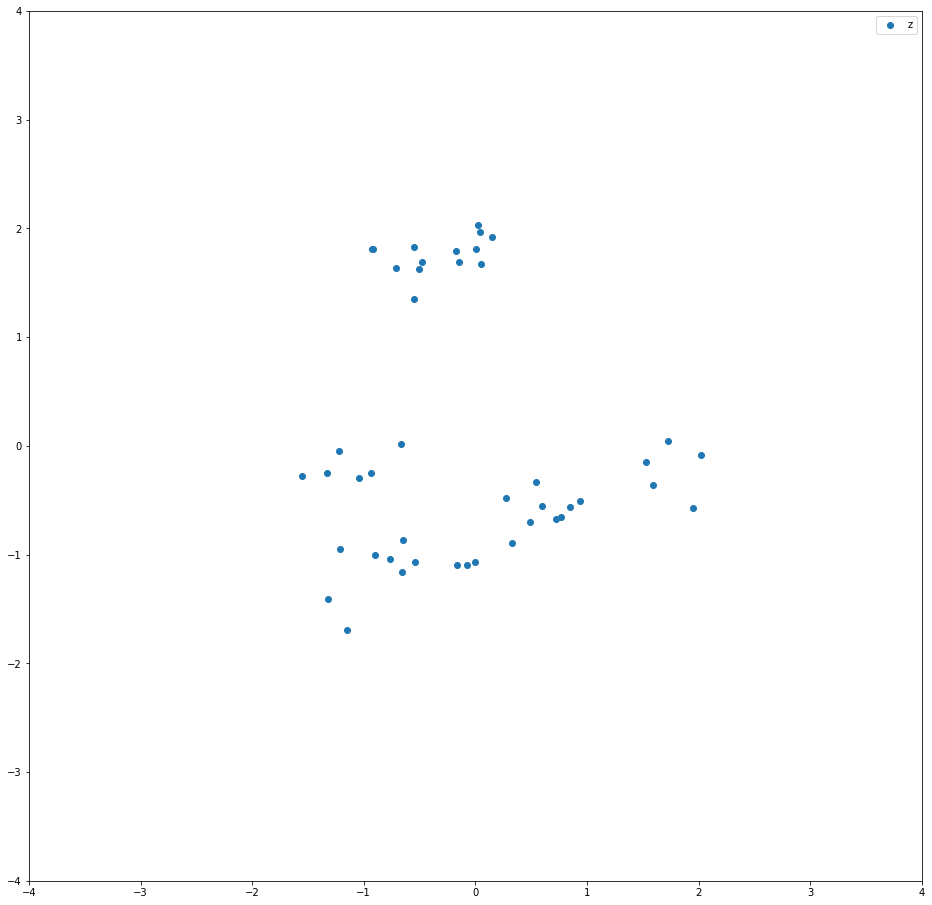

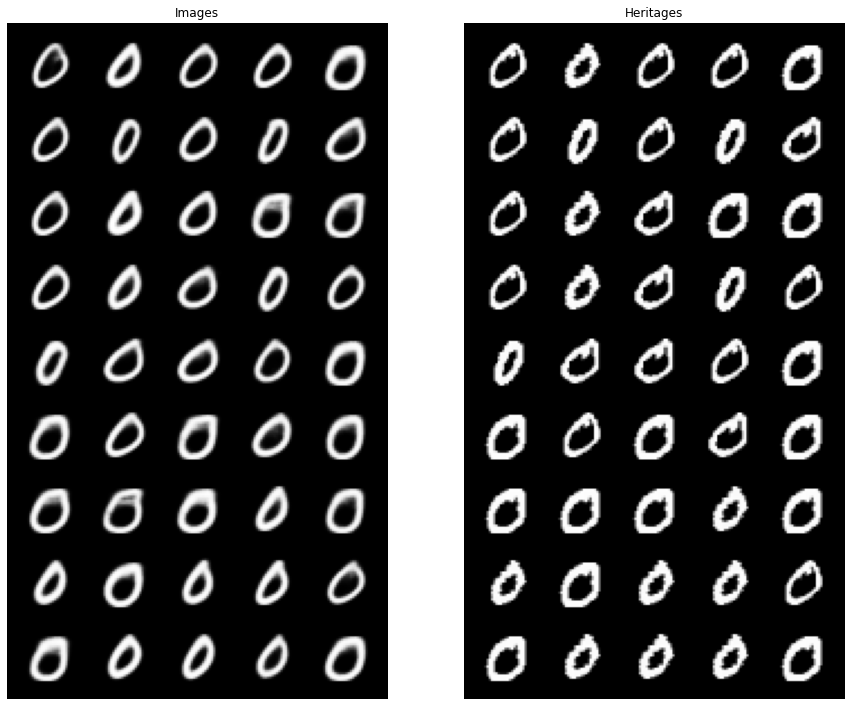

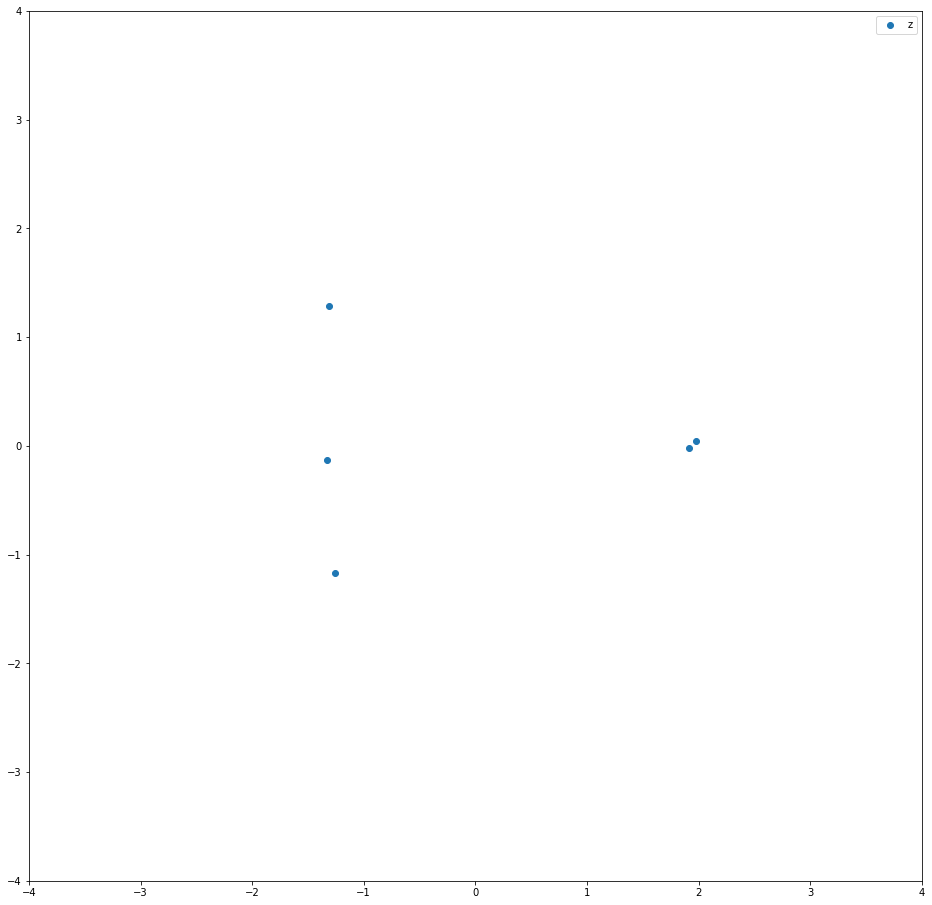

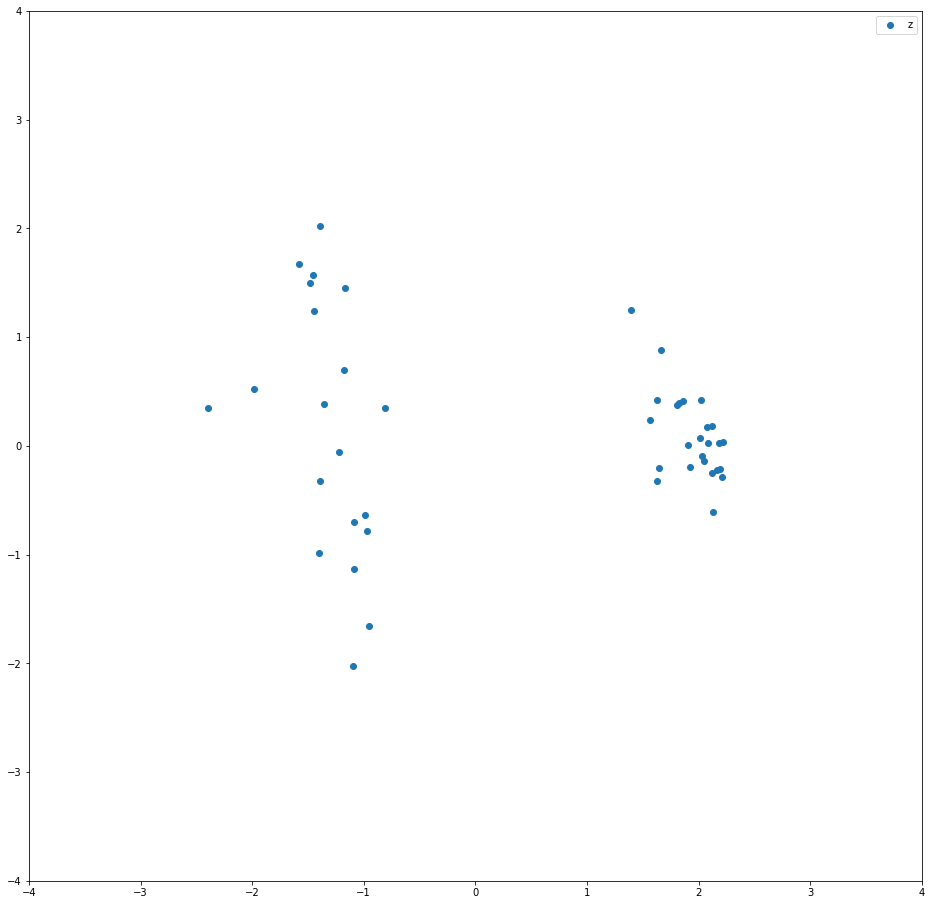

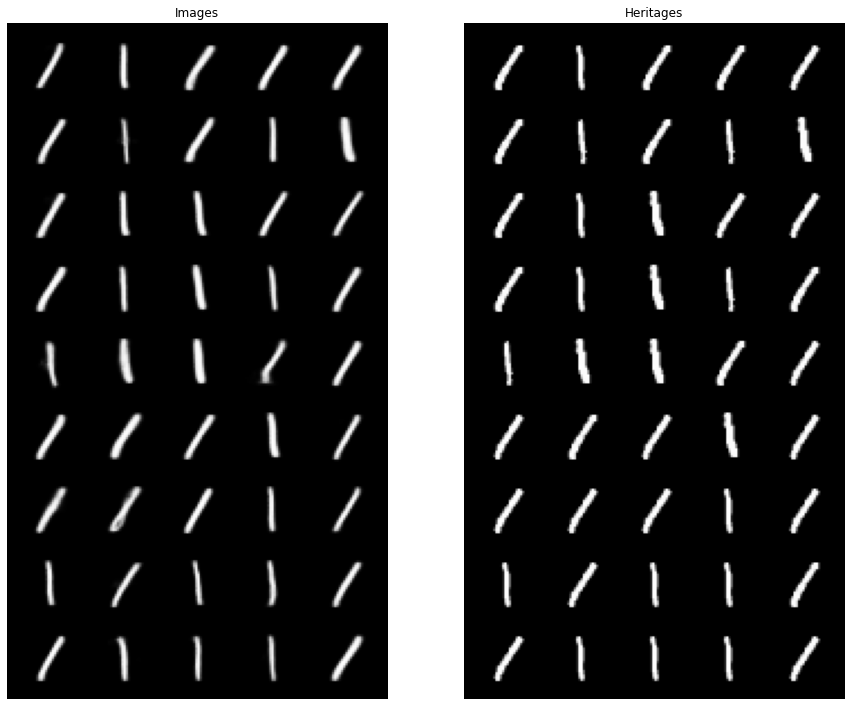

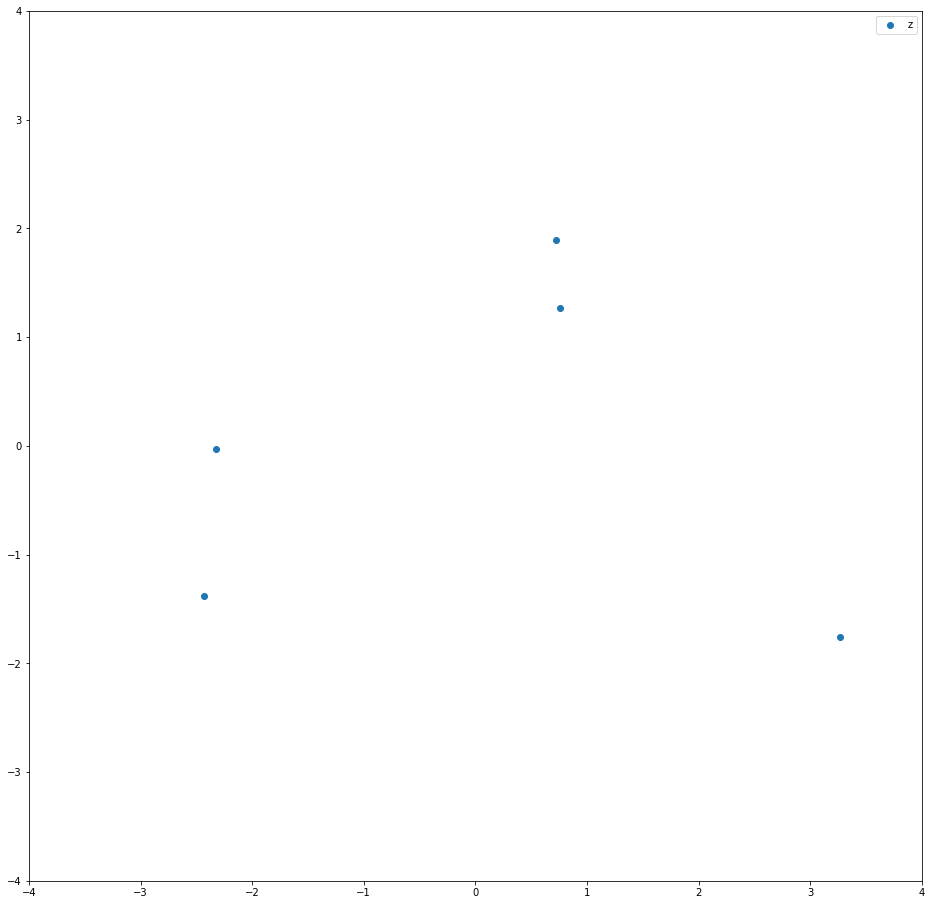

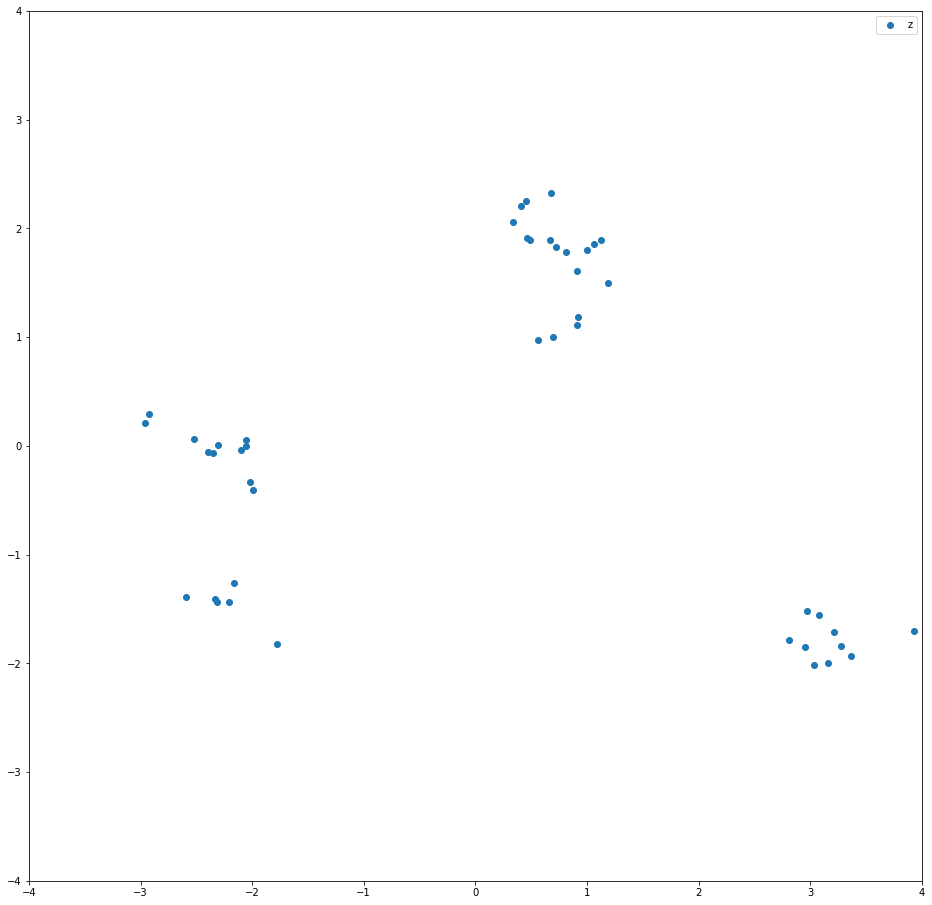

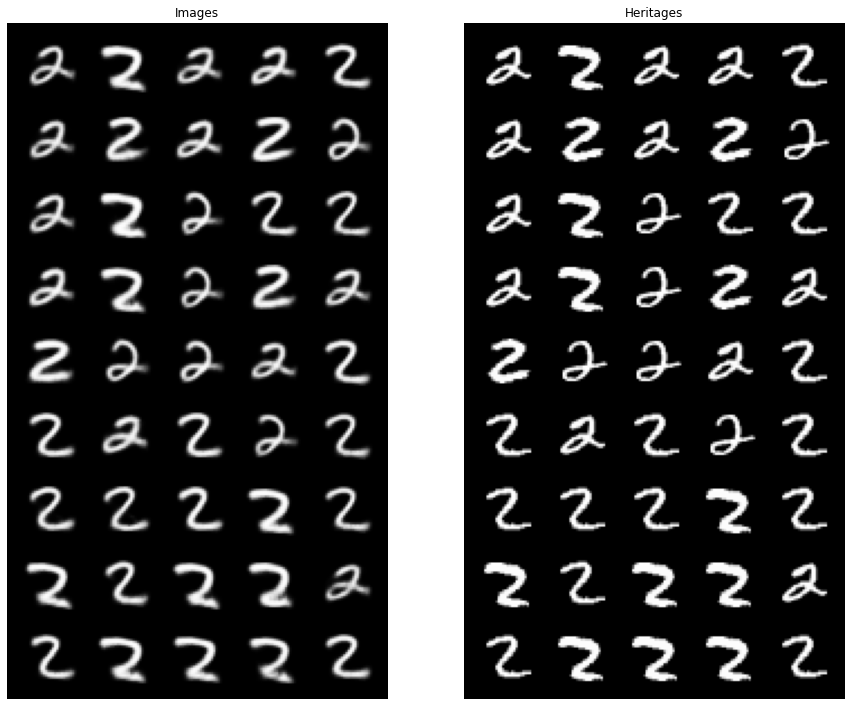

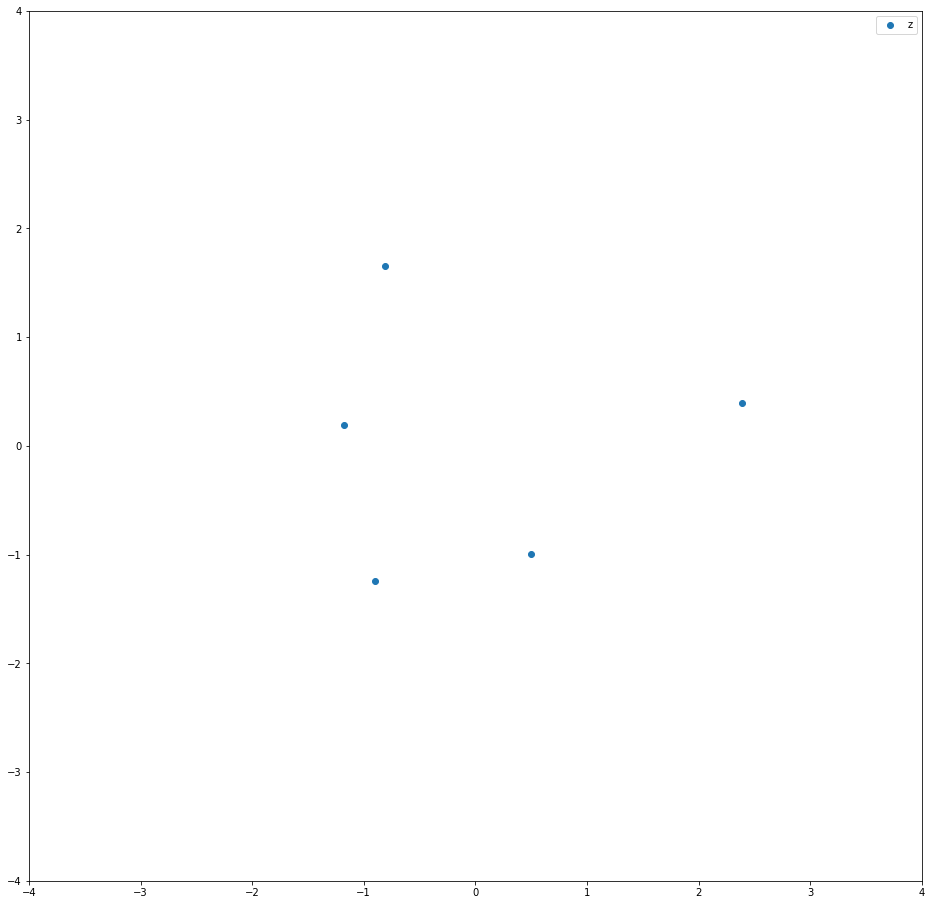

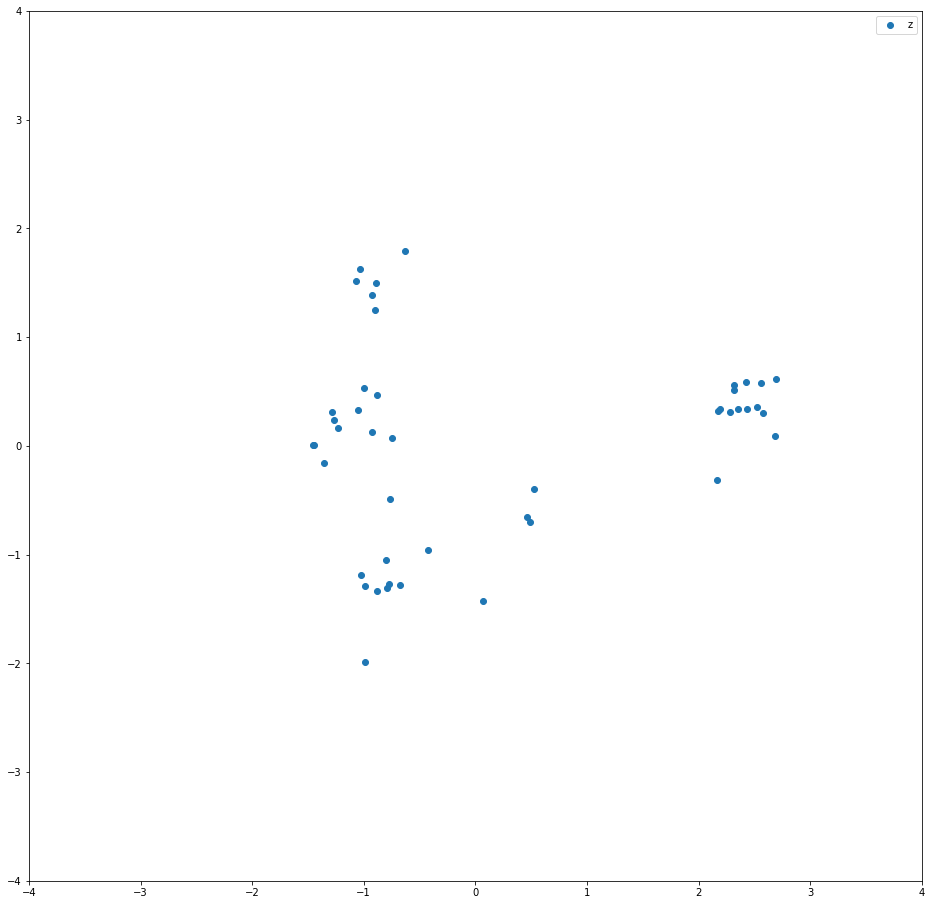

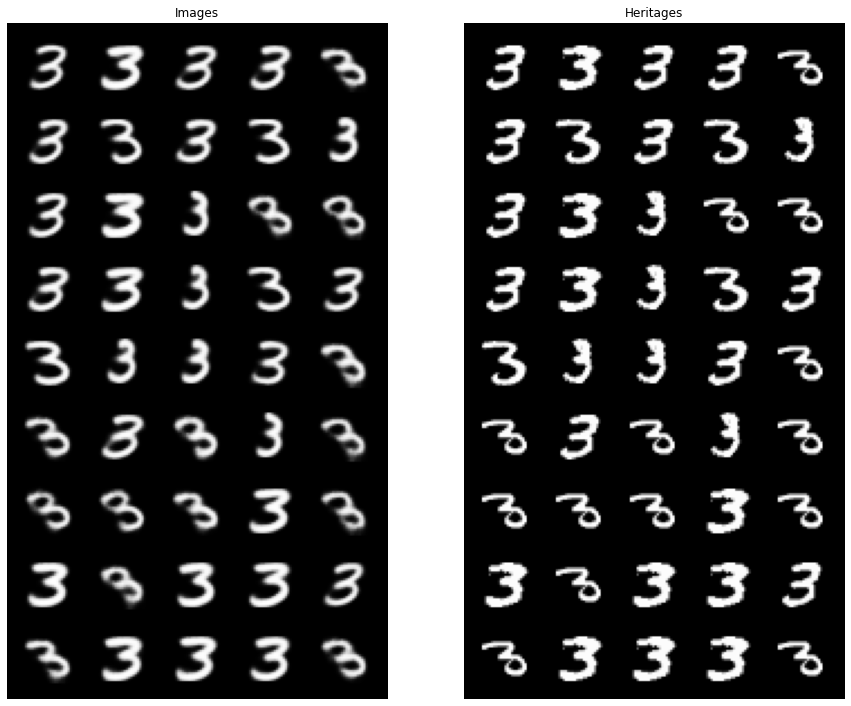

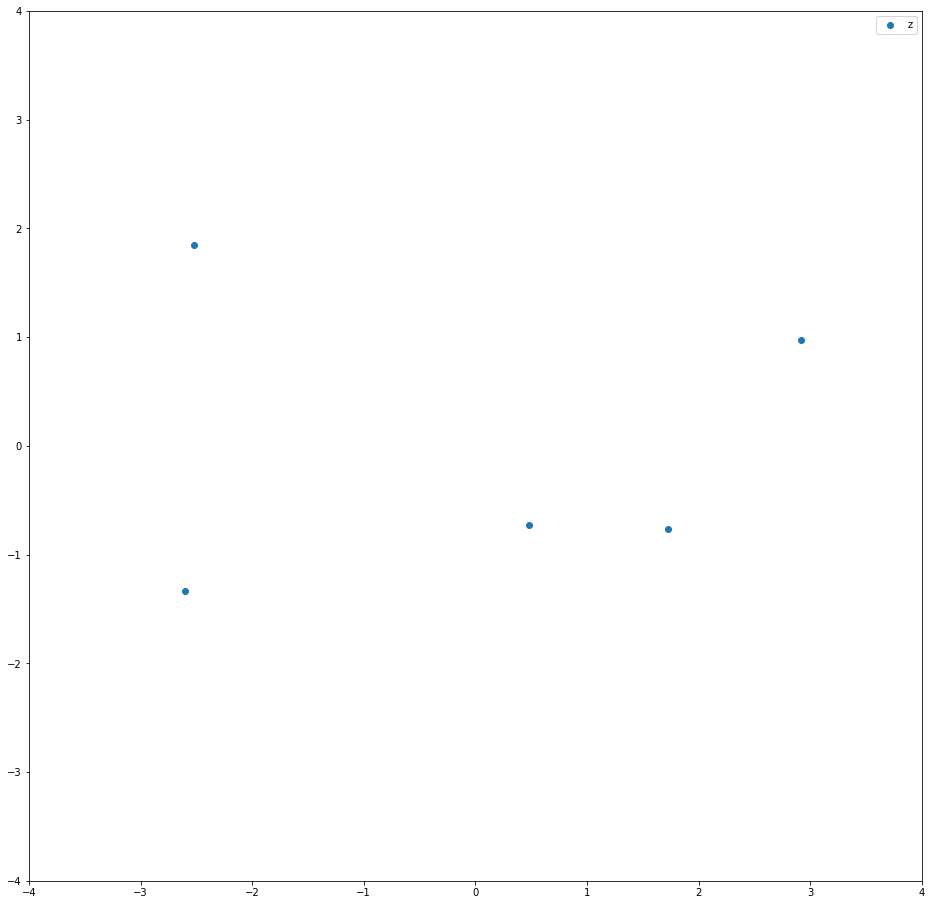

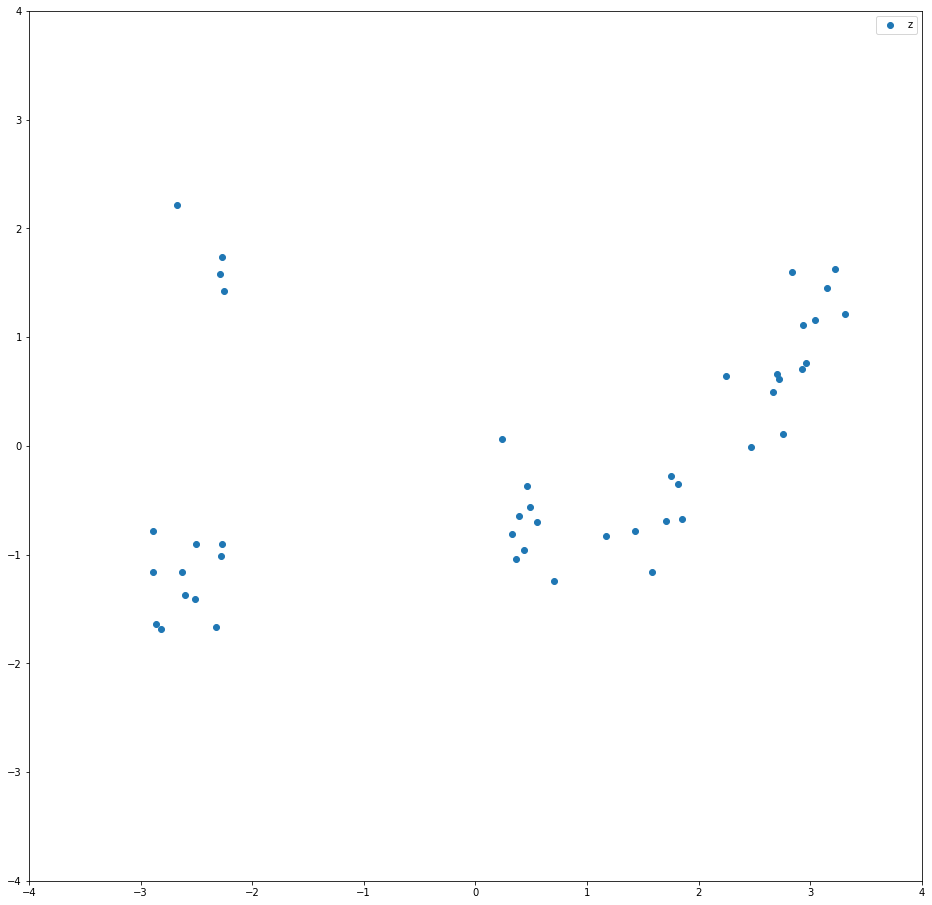

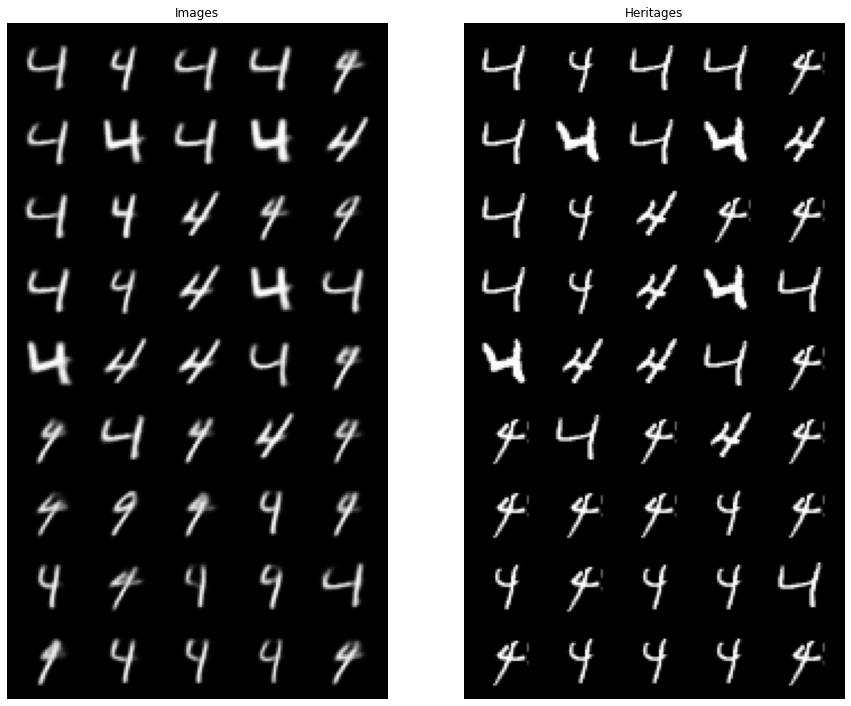

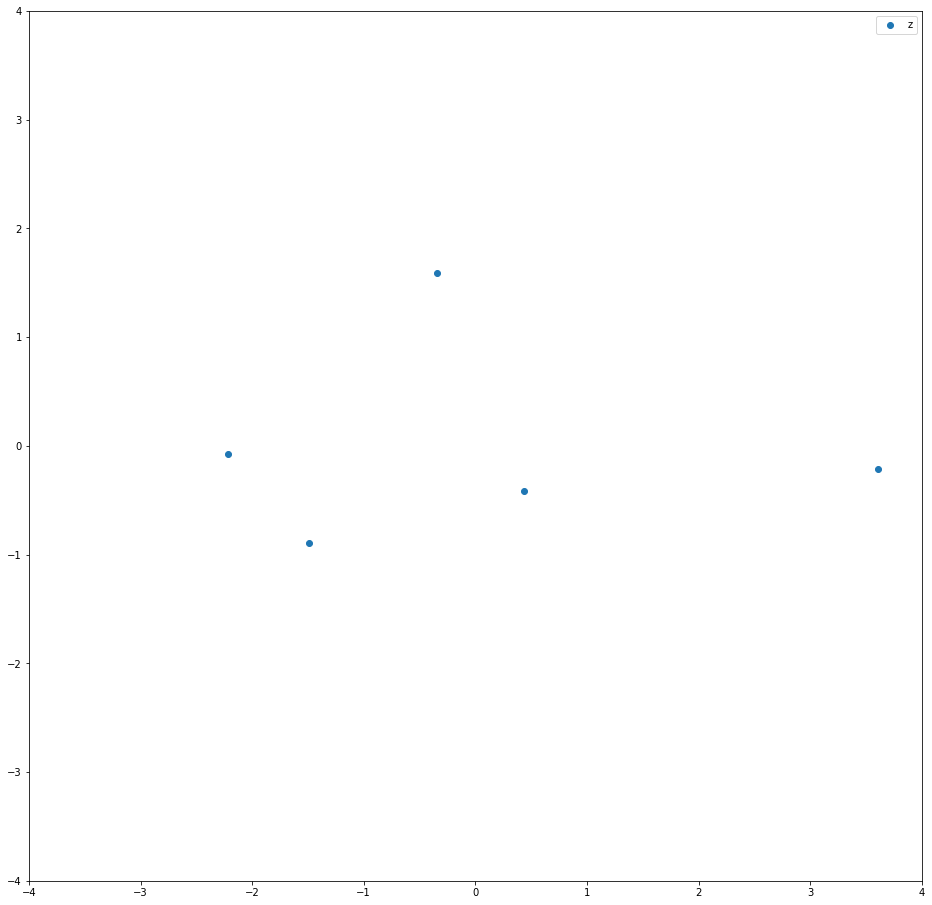

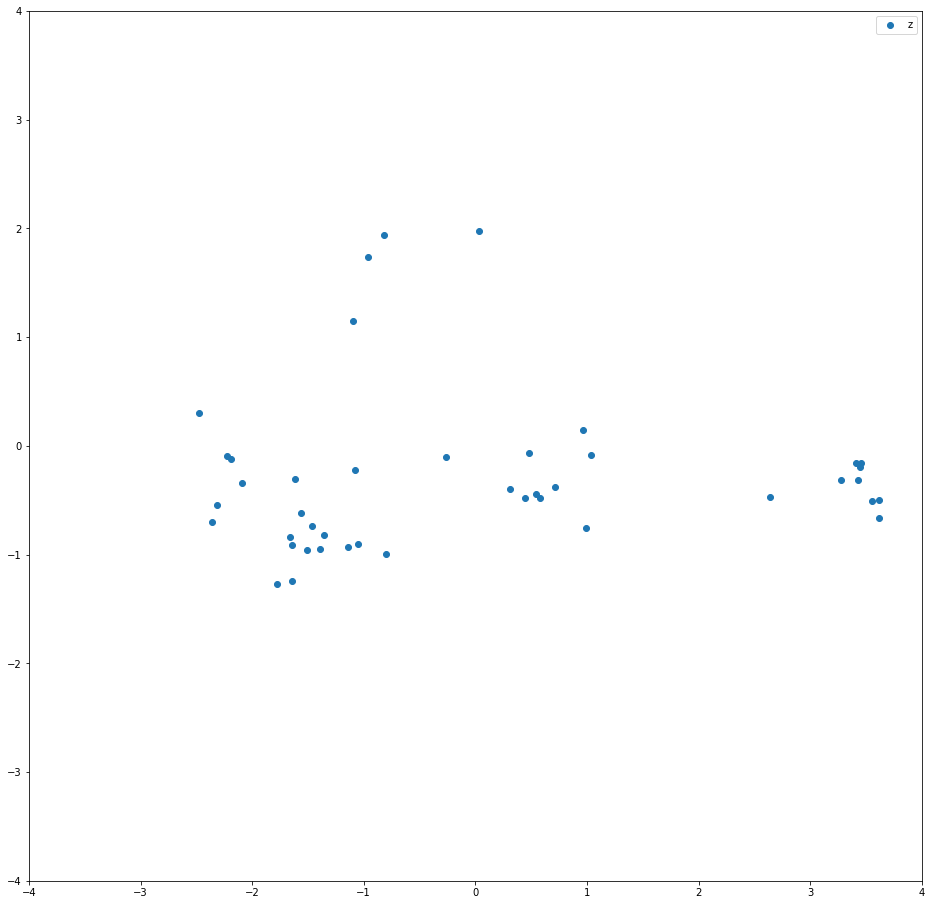

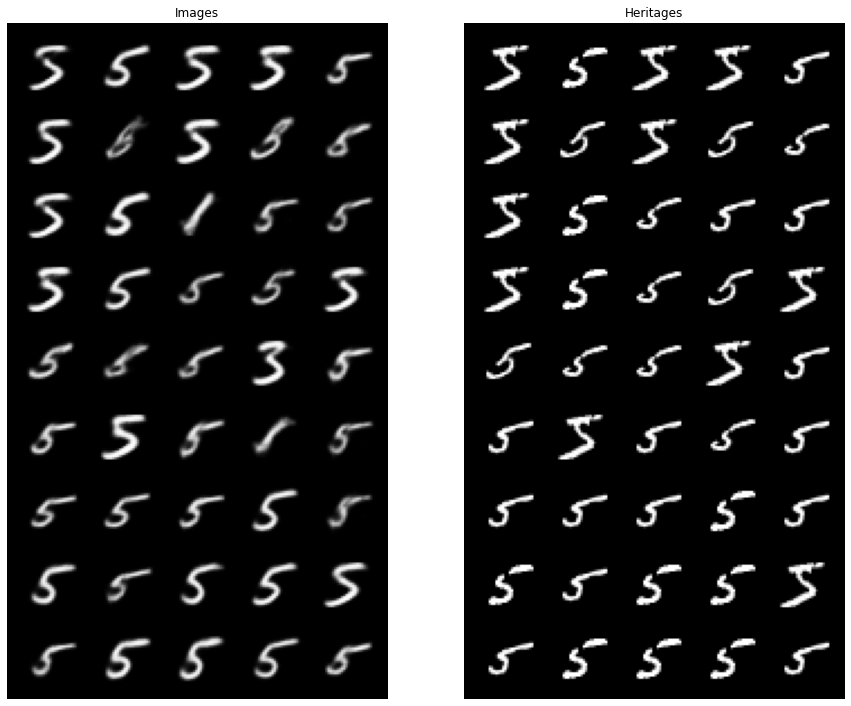

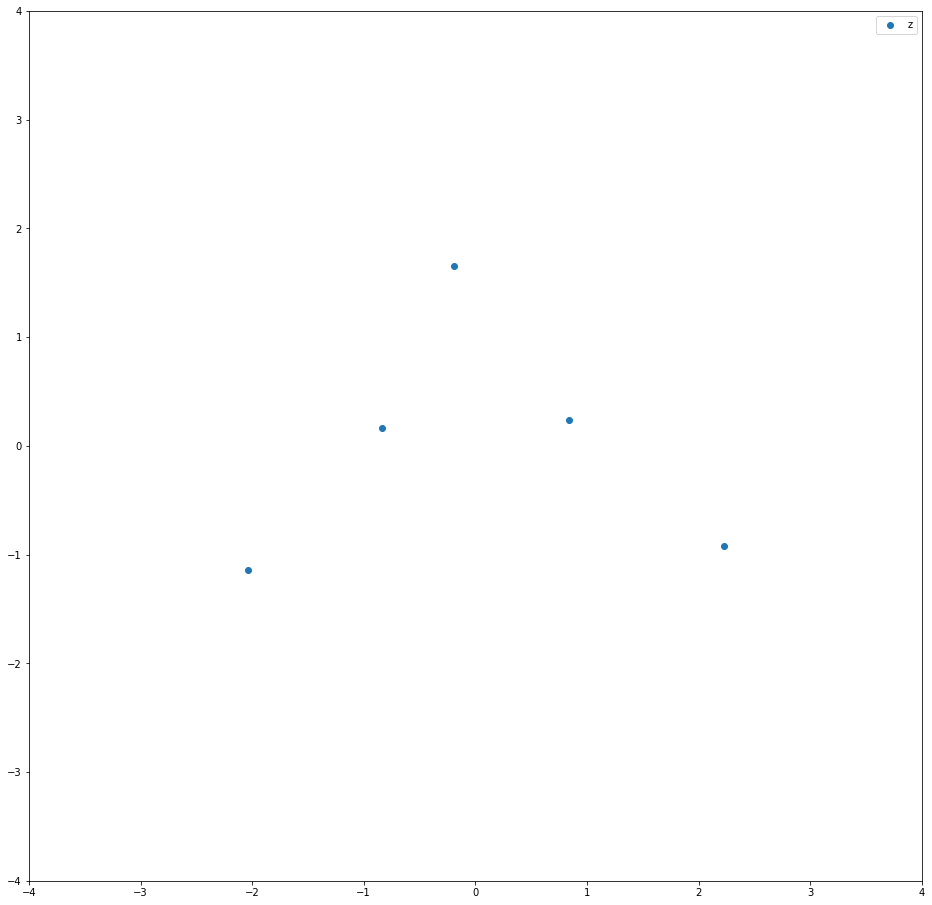

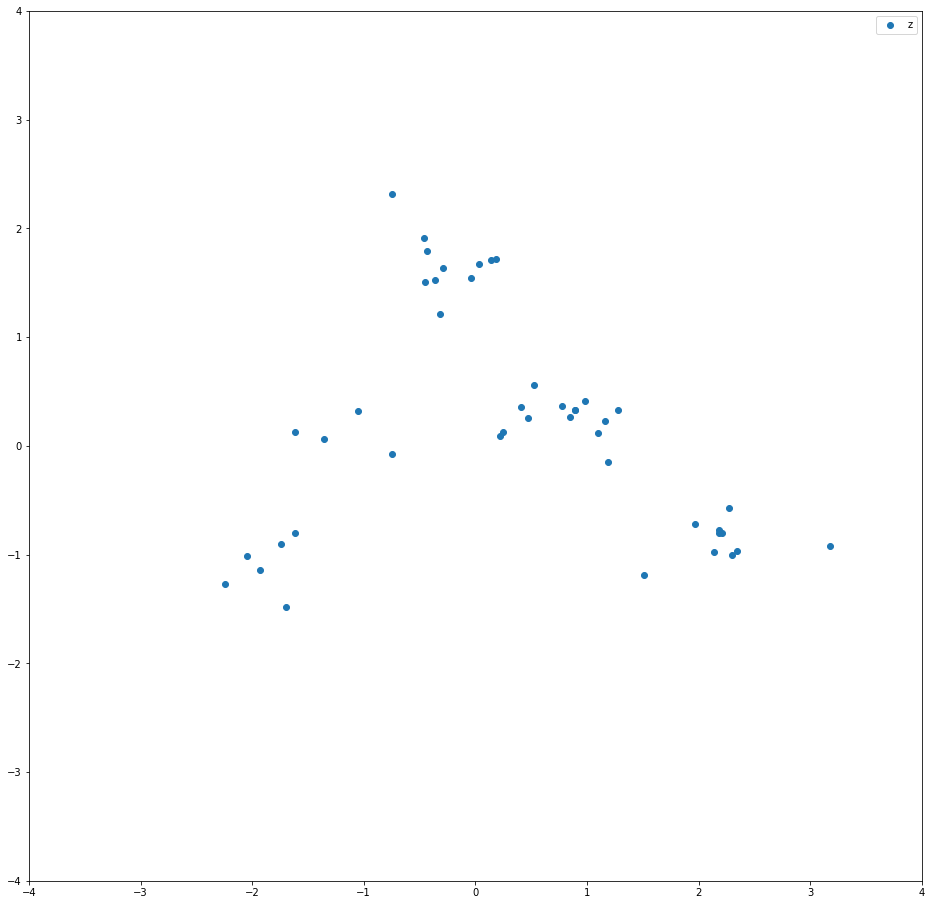

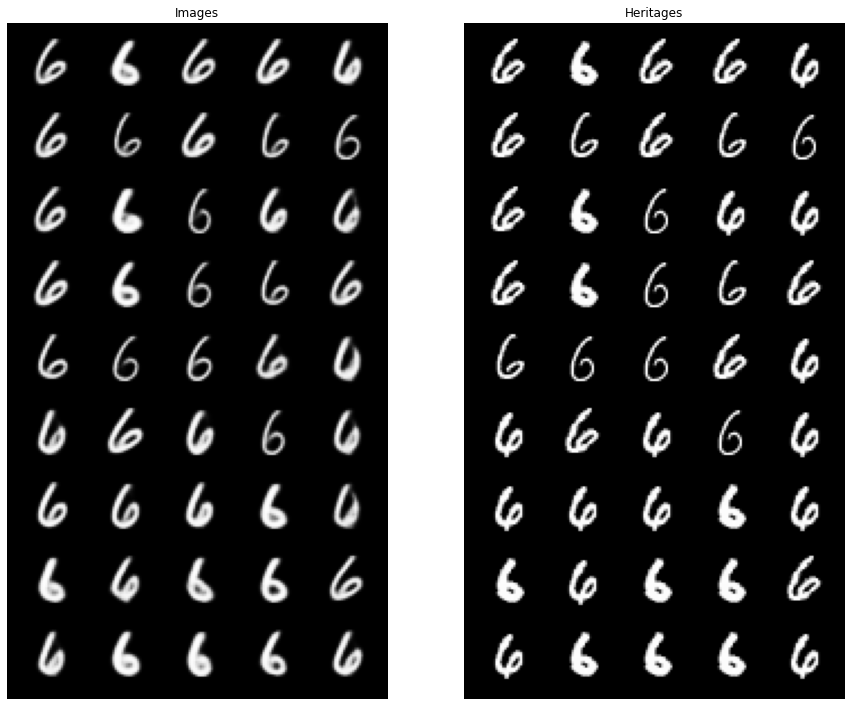

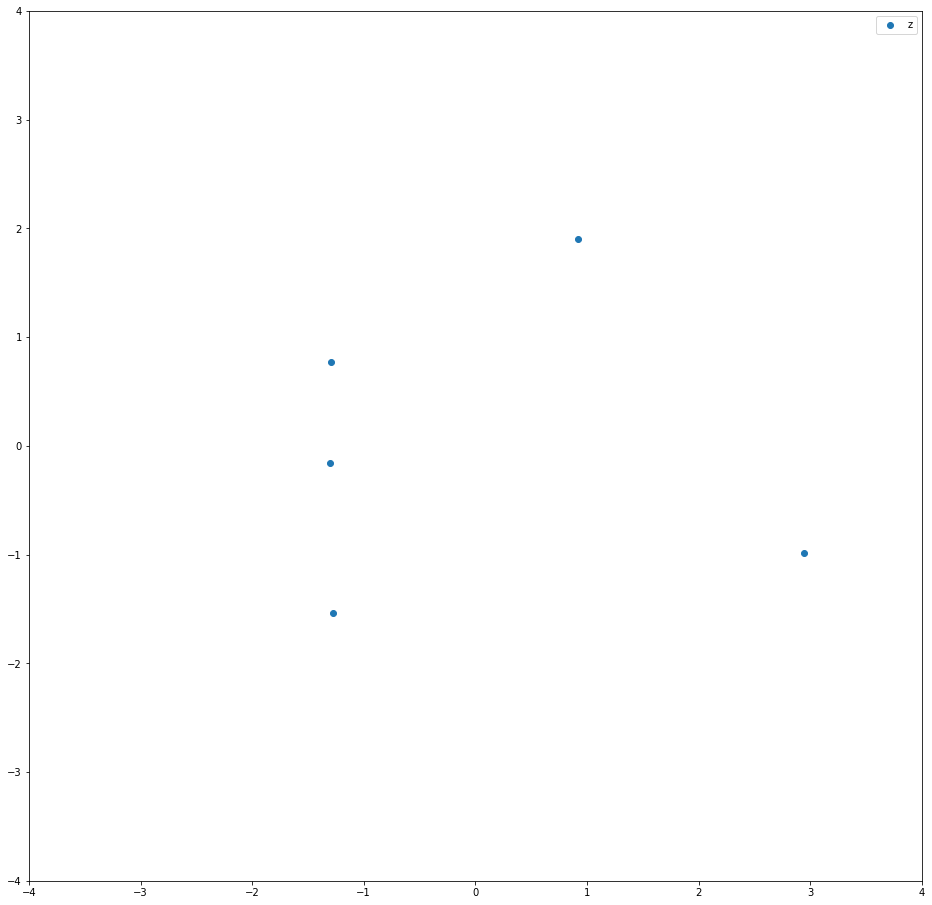

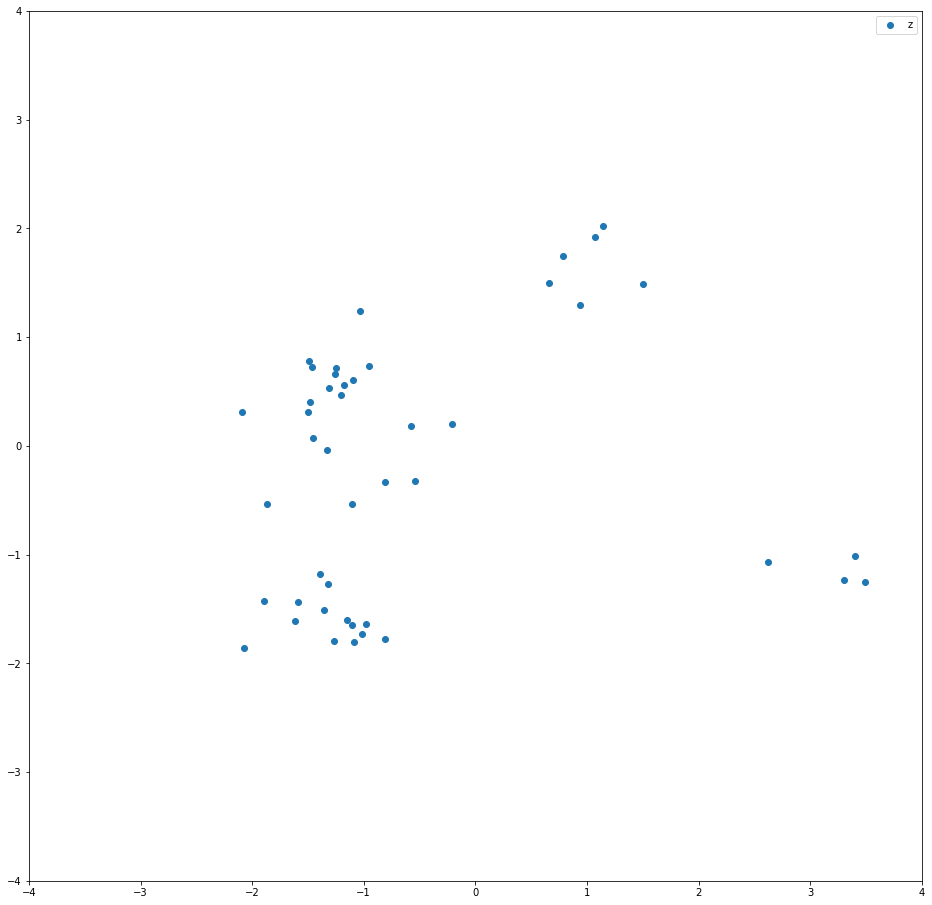

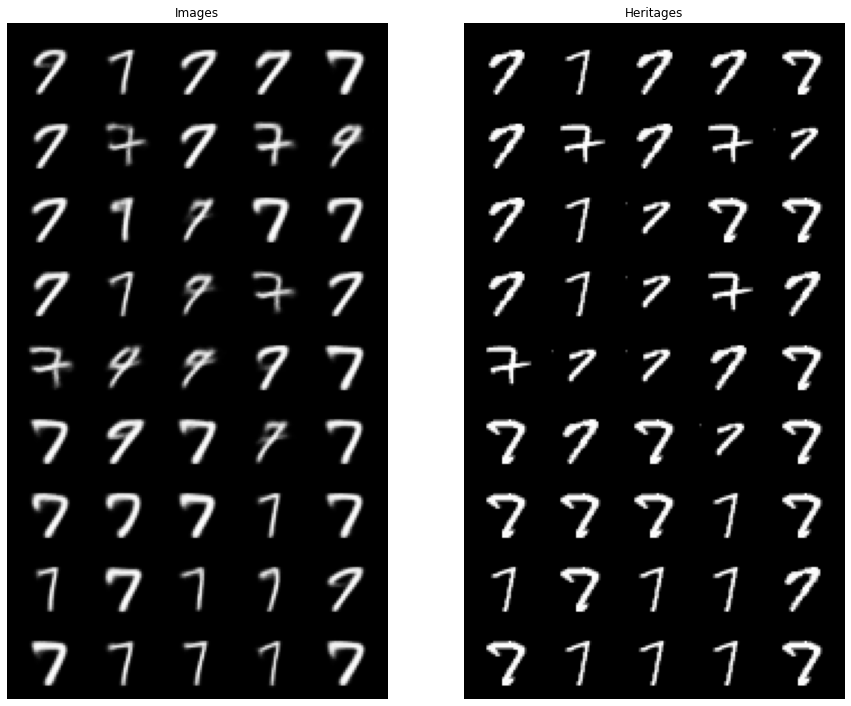

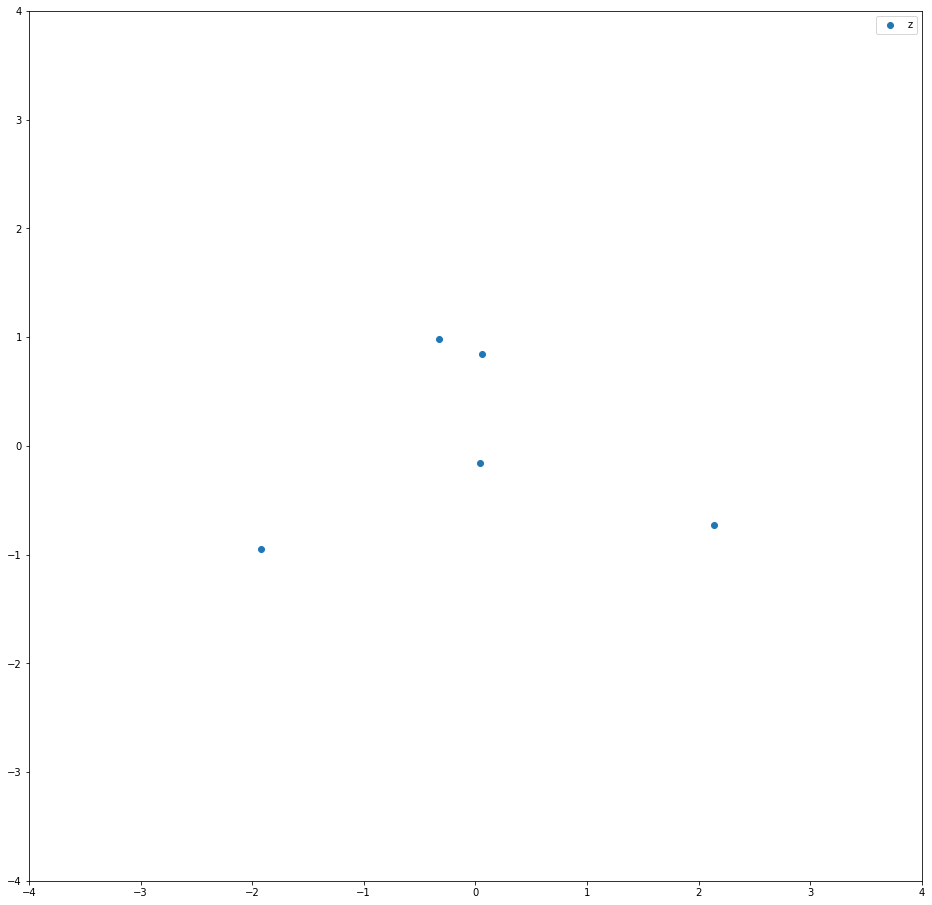

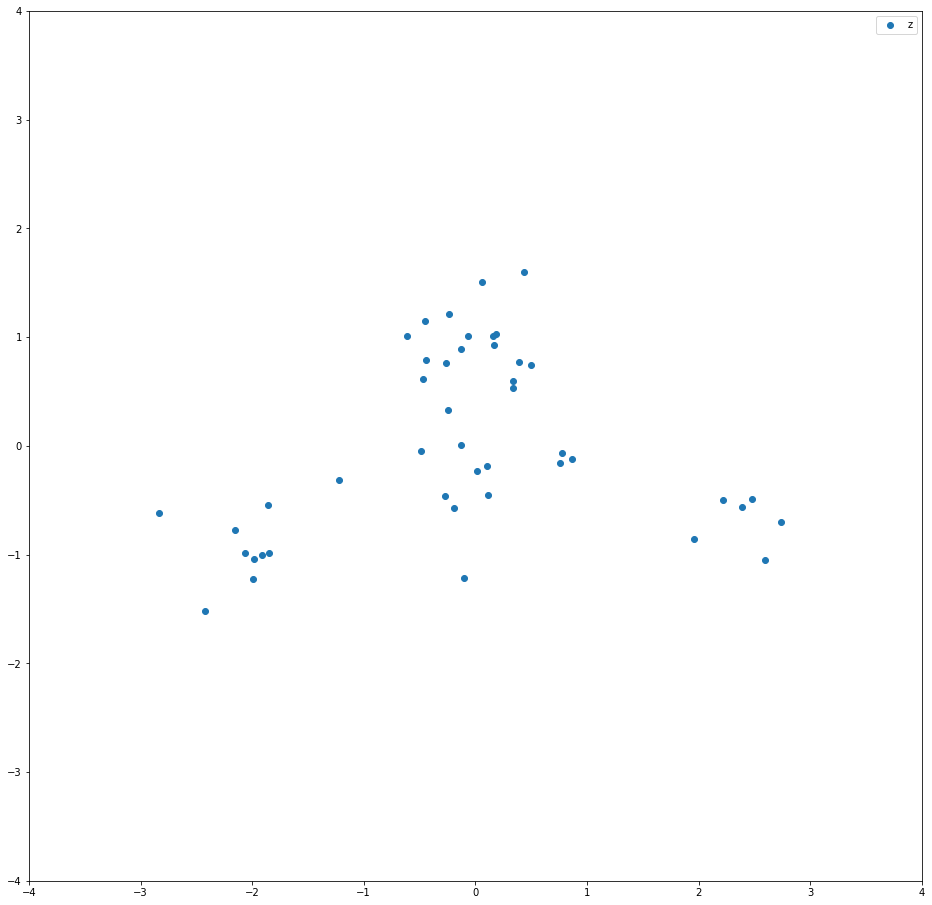

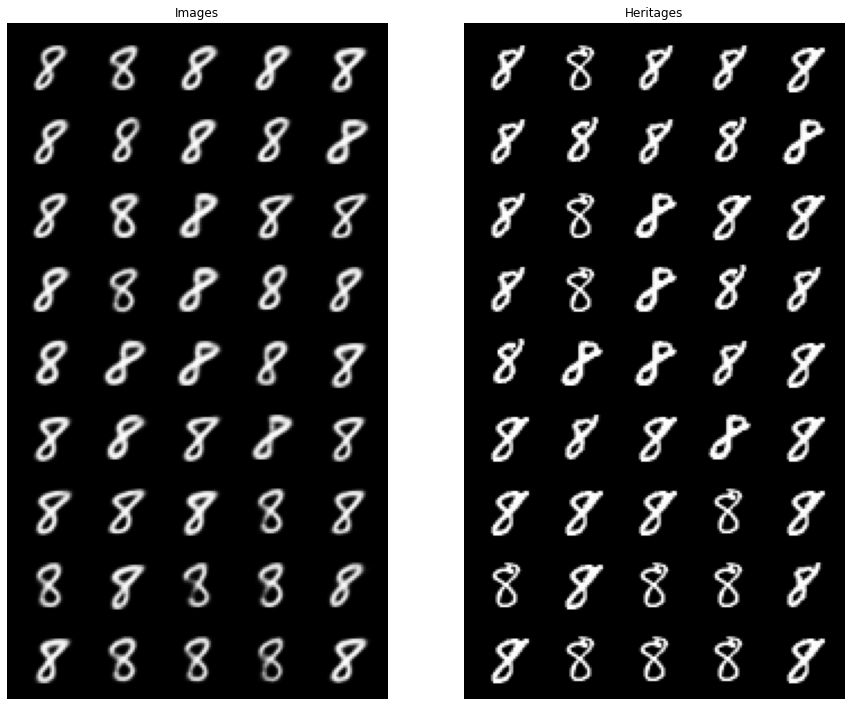

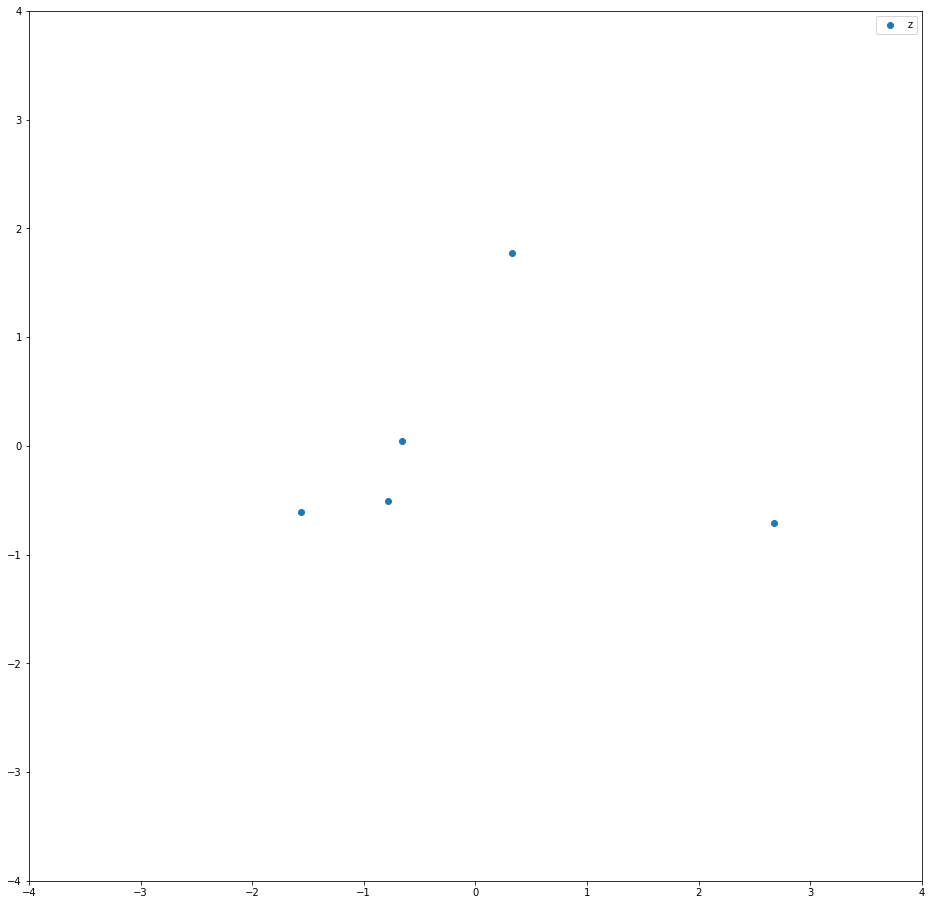

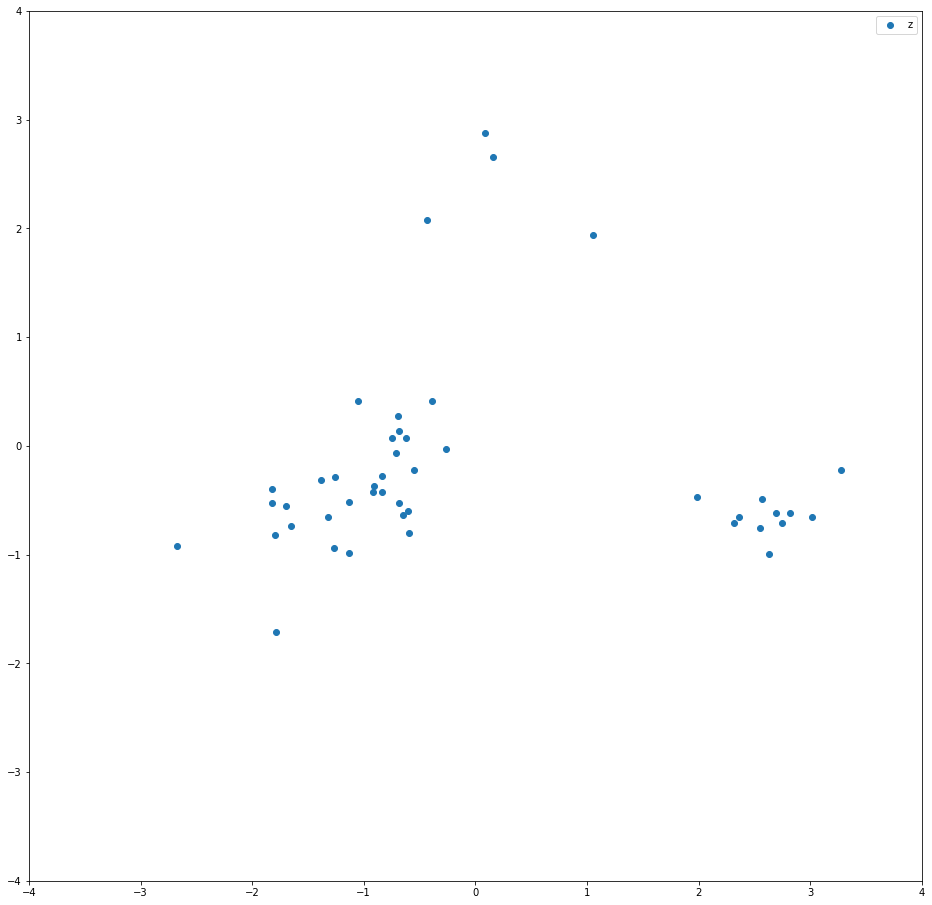

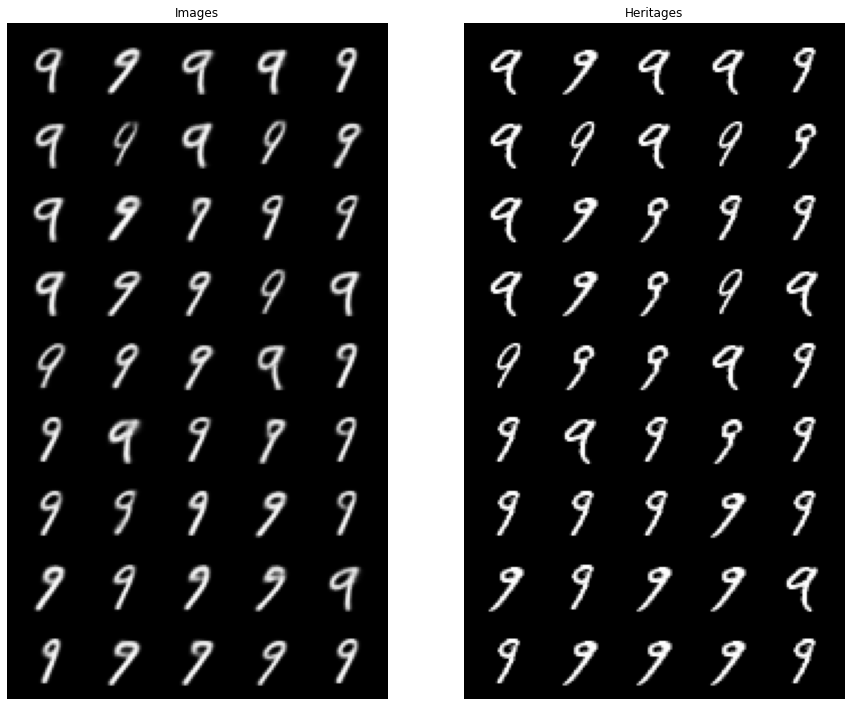

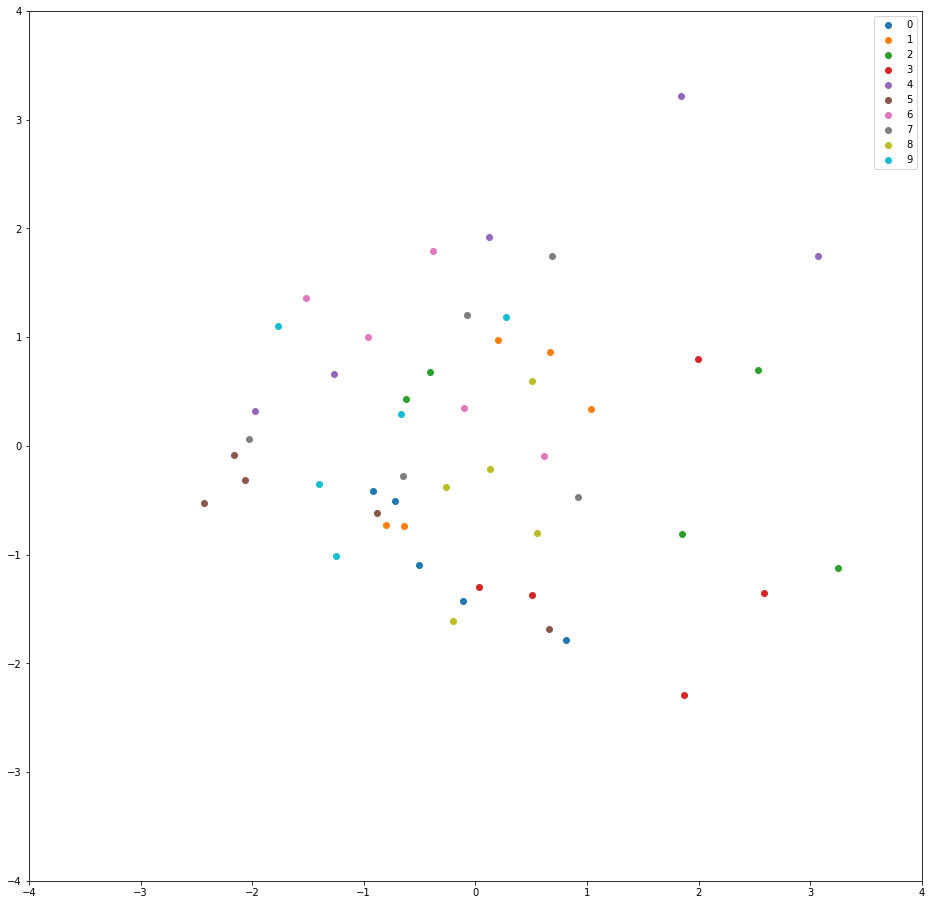

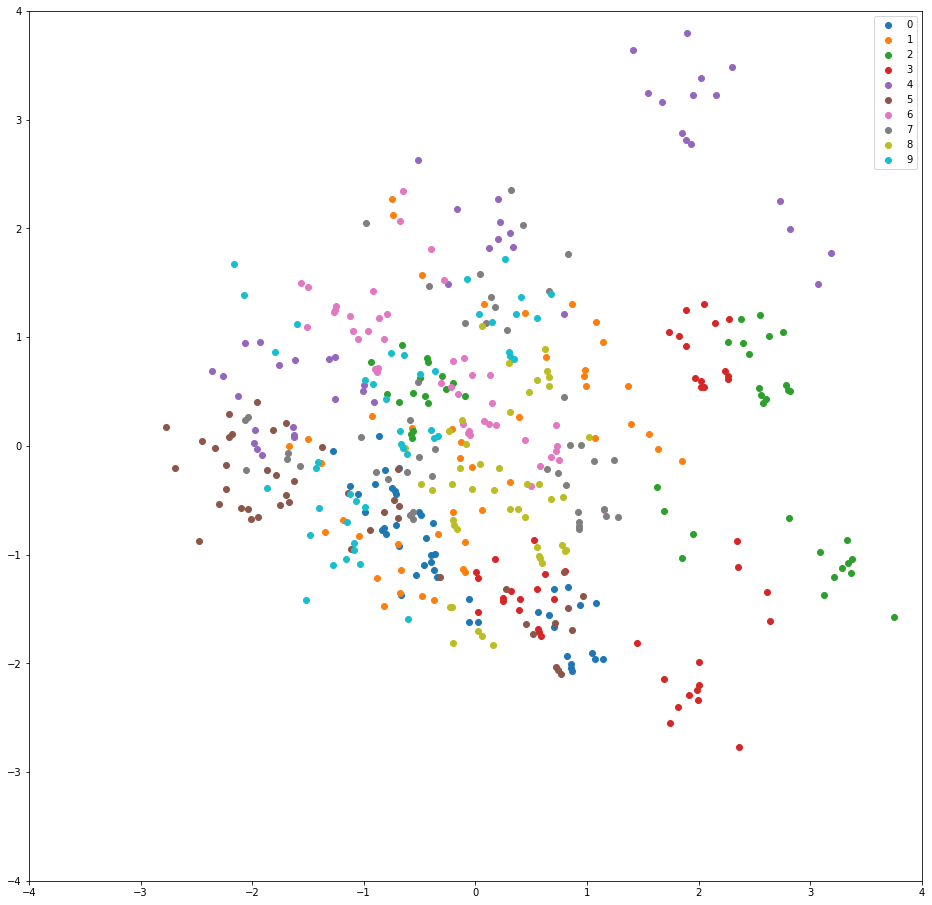

In [4]:
datasets, dataset_info = load_splitted_datasets(DATASET, others=False)
train_dataset, _ = load_unsplitted_dataset(DATASET)

mlflow.set_experiment(f"CNN Z_DIM {Z_DIM}" if AUGMENTATION else "CNN Baseline")
with mlflow.start_run(run_name=AUGMENTATION or "baseline") as run:
    mlflow.log_param("original_dataset_size", len(train_dataset))
    if AUGMENTATION is not None:
        da = DataAugmentation(
            vae_config=VAEConfig(z_dim=Z_DIM, beta=BETA),
            vae_epochs=VAE_EPOCHS,
            multi_vae=MULTI_VAE,
            seed=SEED,
        )

        generated_datasets = da.augment_datasets(datasets, dataset_info, AUGMENTATION, K=K, **augmentation_params)
        train_dataset = ConcatDataset([train_dataset, *generated_datasets])

test_dataset = get_dataset(DATASET, train=False)
print(len(train_dataset))

### The parameters for the classification task

In [ ]:
training_args = TrainingArguments(
    total_steps=5000,
    batch_size=32,
    validation_intervall=200,
    save_model=False,
    seed=SEED,
    early_stopping=False,
    early_stopping_window=20,
    save_best_metric="best_acc",
)

## Training the CNN

In [ ]:
# create a vae config
vae_config = VAEConfig(z_dim=Z_DIM, beta=BETA)
# start mlflow run in experiment
with mlflow.start_run(run.info.run_id):
    # train cnn
    results = train_model(
        model=CNNMNIST(),
        training_args=training_args,
        train_dataset=train_dataset,
        dev_dataset=test_dataset,
        test_dataset=test_dataset,
        seed=SEED,
    )
    # print the results
    print(results)

Training epoch 165:  53%|█████▎    | 2639/5000 [01:00<00:50, 46.54it/s, loss=0.04]